In [47]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from torch.utils.data import random_split
from sklearn.model_selection import KFold
from torch import nn, optim

In [48]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [49]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [68]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [51]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_loss(loss_fn, pred, labels_a, labels_b, lam):
    return lam * loss_fn(pred, labels_a) + (1 - lam) * loss_fn(pred, labels_b)

In [ ]:
# def validation(model, val_loader, loss_fn, train_step):
#     val_preds_list = []
#     val_labels_list = []
#     with torch.no_grad():
#         val_loss = 0.0
#         model.eval()

#         for val_idx, (val_images, val_labels) in enumerate(val_loader):
#             val_images, val_labels = val_images.to(device), val_labels.to(device)

#             val_outputs = model(val_images)
#             _, val_preds = torch.max(val_outputs, 1)

#             val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
            
#             val_preds_list.extend(val_preds.detach().cpu().numpy())
#             val_labels_list.extend(val_labels.detach().cpu().numpy())

#         val_epoch_loss = val_loss / len(val_loader)
#         val_epoch_acc = accuracy_score(val_labels_list, val_preds_list)
#         val_epoch_f1 = f1_score(val_labels_list, val_preds_list, average='macro')
        
#         print("Validation dataset: Val Loss: {:.6f}, Val Acc: {:.4f}, Val F1 Score: {:.4f}".format(val_epoch_loss, val_epoch_acc, val_epoch_f1))
#     return val_epoch_loss, val_epoch_acc, val_epoch_f1

In [ ]:
# def train_per_epoch(epoch, model, trn_loader, loss_fn, optimizer, train_step):
#     preds_list = []
#     labels_list = []

#     for batch_idx, (images, labels) in enumerate(trn_loader):
#         images, labels = images.to(device), labels.to(device)

#         current_loss = 0.0

#         if (batch_idx + 1) % 5 == 0:
#             imgs, labels_a, labels_b, lambda_ = mixup_data(images, labels)
#             output = model(imgs)
#             loss = mixup_loss(loss_fn=loss_fn, pred=output, labels_a=labels_a, labels_b=labels_b, lam=lambda_)
#         else: 
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)
#             loss = loss_fn(outputs, labels)

#             preds_list.extend(preds.detach().cpu().numpy())
#             labels_list.extend(labels.detach().cpu().numpy())

#         # Back propagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         current_loss += loss.item()

#         if (batch_idx + 1) % log_interval == 0:
#             train_loss = current_loss / log_interval
#             train_acc = accuracy_score(labels_list, preds_list)
#             train_f1 = f1_score(labels_list, preds_list, average='macro')

#             print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}, Train Acc: {:.4f}, Train F1 Score: {:.4f}".format(
#                 epoch, 
#                 batch_idx * len(images), 
#                 len(trn_loader) * len(images), 
#                 100 * batch_idx / len(trn_loader), 
#                 train_loss, 
#                 train_acc,
#                 train_f1))

#         train_step += 1

#     return train_step, current_loss / len(trn_loader), accuracy_score(labels_list, preds_list), f1_score(labels_list, preds_list, average='macro')
    


In [54]:
df = pd.read_csv('/root/CV_PJT/CV_PJT/code/trin4.csv')
sample_submission_df = pd.read_csv("/root/CV_PJT/CV_PJT/data/data/sample_submission.csv")

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model config
model_name = 'efficientnet_b3'

# training config
img_size = 260
LR = 1e-4
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0
log_interval = 100

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [56]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2
from augraphy import *
from augraphy.base.augmentationsequence import AugmentationSequence
from augraphy.augmentations import *

In [57]:
trn_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])
# Post-processing and Test-Time Augmentation (TTA)
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    # Minimal augmentations to simulate test conditions
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])
trn_dataset = ImageDataset("/root/CV_PJT/CV_PJT/code/trin4.csv", "/root/CV_PJT/CV_PJT/data/data/train", transform=trn_transform)
tst_dataset = ImageDataset("/root/CV_PJT/CV_PJT/data/data/sample_submission.csv", "/root/CV_PJT/CV_PJT/data/data/test", transform=tst_transform)
len(trn_dataset), len(tst_dataset) 

(369040, 3140)

In [58]:
# Dataset definition
full_dataset = ImageDataset(
    "/root/CV_PJT/CV_PJT/code/trin4.csv",
    "/root/CV_PJT/CV_PJT/data/data/train",
    transform=trn_transform
)

# Calculate the total number of samples in the dataset
dataset_size = len(full_dataset)

# Define the ratios for training and validation
train_ratio = 0.8  # Use 80% of the data for training
val_ratio = 1 - train_ratio  # Remaining 20% for validation

# Calculate the number of samples for training and validation
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size  # Ensure all samples are accounted for

# Split the dataset into training and validation sets
trn_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Define the test dataset
tst_dataset = ImageDataset(
    "/root/CV_PJT/CV_PJT/data/data/sample_submission.csv",
    "/root/CV_PJT/CV_PJT/data/data/test",
    transform=tst_transform
)

# Print the sizes of the datasets
print("Training dataset size:", len(trn_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(tst_dataset))

Training dataset size: 295232
Validation dataset size: 73808
Test dataset size: 3140


In [69]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

# val_loader = DataLoader(
#     val_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=True
# )

tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [60]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [61]:
from datetime import datetime

In [66]:
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)
optimizer_name = type(optimizer).__name__


In [70]:
for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    log = ""
    for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
    print(log)

Loss: 0.0090: 100%|██████████| 9226/9226 [40:19<00:00,  3.81it/s]


train_loss: 0.0930
train_acc: 0.9678
train_f1: 0.9678
epoch: 0.0000



Loss: 0.0037: 100%|██████████| 9226/9226 [39:51<00:00,  3.86it/s]


train_loss: 0.0097
train_acc: 0.9969
train_f1: 0.9969
epoch: 1.0000



Loss: 0.0002: 100%|██████████| 9226/9226 [40:13<00:00,  3.82it/s]


train_loss: 0.0059
train_acc: 0.9980
train_f1: 0.9980
epoch: 2.0000



Loss: 0.0000: 100%|██████████| 9226/9226 [40:16<00:00,  3.82it/s]


train_loss: 0.0044
train_acc: 0.9986
train_f1: 0.9986
epoch: 3.0000



Loss: 0.0000: 100%|██████████| 9226/9226 [39:52<00:00,  3.86it/s]


train_loss: 0.0036
train_acc: 0.9988
train_f1: 0.9988
epoch: 4.0000



Loss: 0.0000: 100%|██████████| 9226/9226 [39:34<00:00,  3.89it/s]


train_loss: 0.0030
train_acc: 0.9991
train_f1: 0.9991
epoch: 5.0000



Loss: 0.0003: 100%|██████████| 9226/9226 [39:33<00:00,  3.89it/s]


train_loss: 0.0026
train_acc: 0.9992
train_f1: 0.9992
epoch: 6.0000



Loss: 0.0000: 100%|██████████| 9226/9226 [39:33<00:00,  3.89it/s]


train_loss: 0.0022
train_acc: 0.9993
train_f1: 0.9993
epoch: 7.0000



Loss: 0.0000: 100%|██████████| 9226/9226 [39:35<00:00,  3.88it/s]


train_loss: 0.0022
train_acc: 0.9994
train_f1: 0.9994
epoch: 8.0000



Loss: 0.0000: 100%|██████████| 9226/9226 [39:33<00:00,  3.89it/s]


train_loss: 0.0018
train_acc: 0.9995
train_f1: 0.9995
epoch: 9.0000



Loss: 0.0013: 100%|██████████| 9226/9226 [39:31<00:00,  3.89it/s]


train_loss: 0.0020
train_acc: 0.9995
train_f1: 0.9995
epoch: 10.0000



Loss: 0.0000: 100%|██████████| 9226/9226 [39:47<00:00,  3.86it/s]


train_loss: 0.0015
train_acc: 0.9995
train_f1: 0.9995
epoch: 11.0000



Loss: 0.0001: 100%|██████████| 9226/9226 [40:19<00:00,  3.81it/s]


train_loss: 0.0017
train_acc: 0.9995
train_f1: 0.9995
epoch: 12.0000



Loss: 0.0000: 100%|██████████| 9226/9226 [39:45<00:00,  3.87it/s]


train_loss: 0.0014
train_acc: 0.9996
train_f1: 0.9996
epoch: 13.0000



Loss: 0.0000:  74%|███████▍  | 6871/9226 [30:00<10:16,  3.82it/s]


KeyboardInterrupt: 

In [71]:
import os
import torch

# Define folder and filename
folder_path = "/root/CV_PJT/CV_PJT/model"
os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist
file_path = os.path.join(folder_path, "entire_model_effib3.pth")

# Save the model weights
torch.save(model, file_path)
print(f"Model saved at {file_path}")

Model saved at /root/CV_PJT/CV_PJT/model/entire_model_effib3.pth


In [ ]:
# PyTorch load example
# model.load_state_dict(torch.load("./saved_models/model_weights.pth"))

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [72]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:16<00:00,  6.13it/s]


In [73]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [74]:
sample_submission_df = pd.read_csv("/root/CV_PJT/CV_PJT/data/data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [75]:
pred_df.to_csv("pred_15.csv", index=False)

In [ ]:
len(pred_df)

3140

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

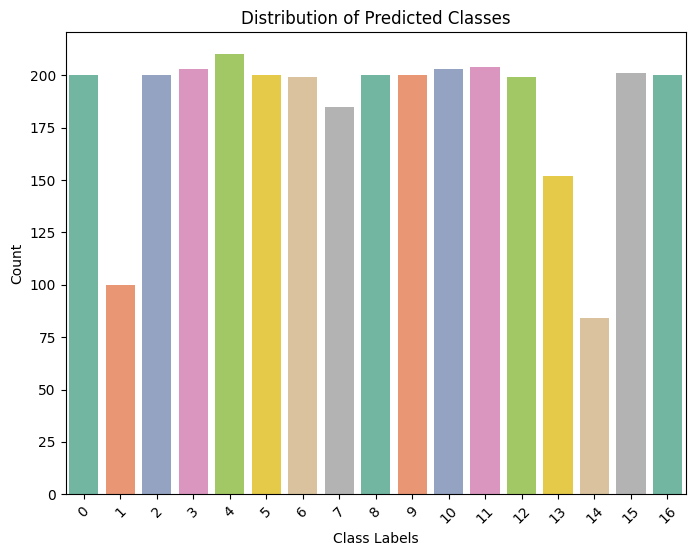

In [77]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Count the number of predictions per class
sns.countplot(x='target', data=pred_df, palette='Set2')
plt.title('Distribution of Predicted Classes')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1460
           1       1.00      1.00      1.00      1334
           2       1.00      1.00      1.00      1428
           3       1.00      1.00      1.00      1381
           4       1.00      1.00      1.00      1378
           5       1.00      1.00      1.00      1394
           6       1.00      1.00      1.00      1378
           7       1.00      1.00      1.00      1412
           8       1.00      1.00      1.00      1433
           9       1.00      1.00      1.00      1417
          10       1.00      1.00      1.00      1331
          11       1.00      1.00      1.00      1378
          12       1.00      1.00      1.00      1407
          13       1.00      1.00      1.00      1404
          14       1.00      1.00      1.00      1399
          15       1.00      1.00      1.00      1323
          16       1.00      1.00      1.00      1420

    accuracy              

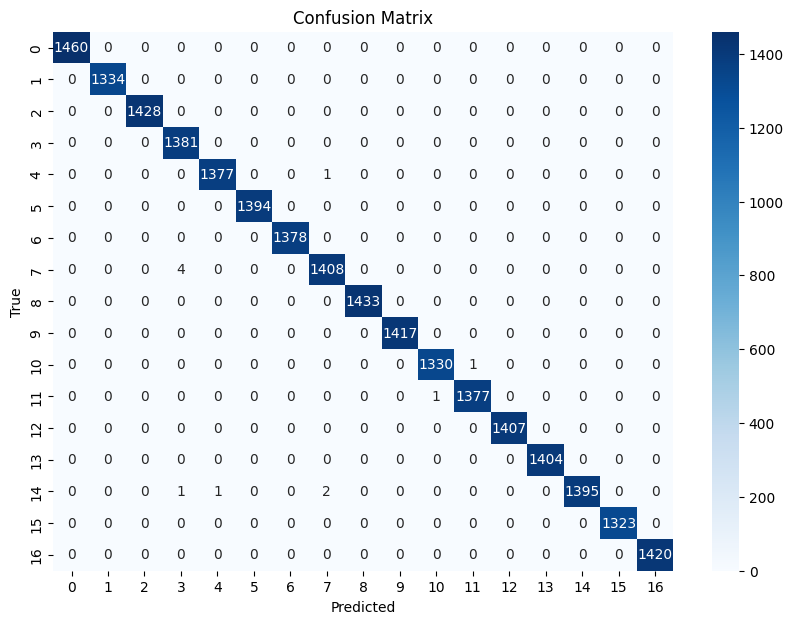

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8382571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.106231].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1410893].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9776906].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.960

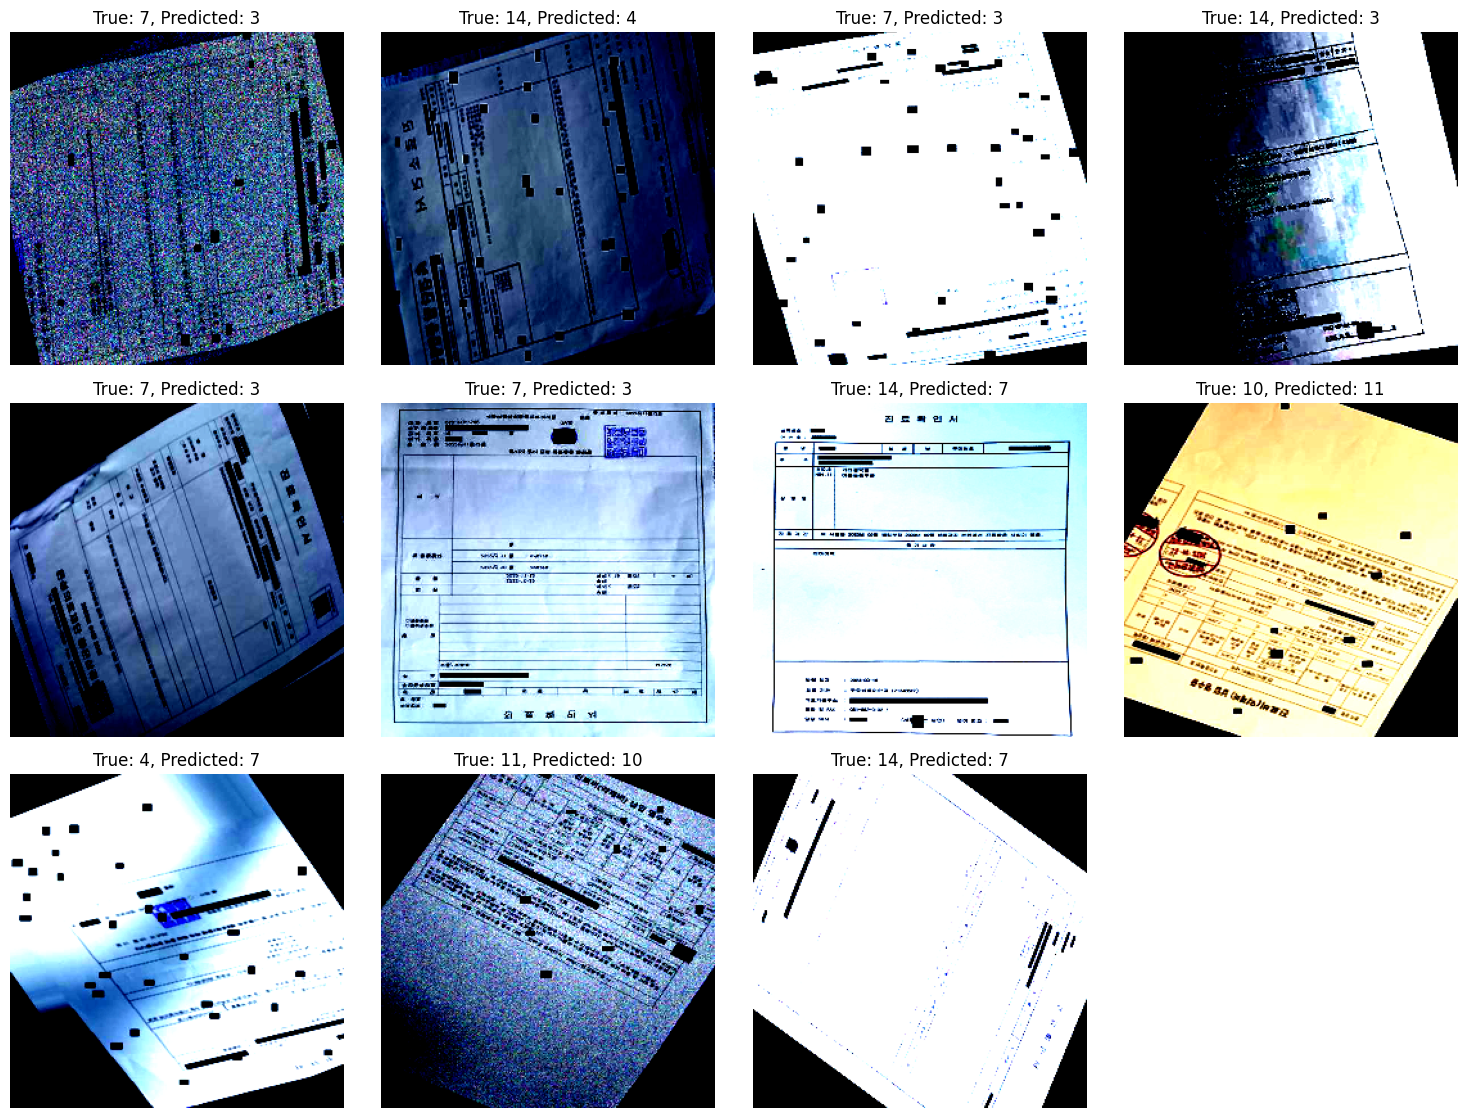

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define your class names based on your dataset
class_names = [str(i) for i in range(17)]  # Class names from '0' to '16'

# Get predictions on validation set
all_preds = []
all_labels = []
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Identify misclassified images
        for i in range(len(labels)):
            if preds[i] != labels[i]:  # If prediction is incorrect
                misclassified_images.append(images[i].cpu())  # Store misclassified image
                misclassified_labels.append(labels[i].cpu().numpy())  # Store true label
                misclassified_preds.append(preds[i].cpu().numpy())  # Store predicted label

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualizing Misclassified Images
num_images = min(len(misclassified_images), 16)  # Display up to 16 images
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)  # 4x4 grid for images
    plt.imshow(misclassified_images[i].permute(1, 2, 0))  # Change channel order for plotting
    plt.title(f'True: {misclassified_labels[i]}, Predicted: {misclassified_preds[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()
